<a href="https://colab.research.google.com/github/srini229/EE5333_tutorials/blob/master/fp/Floorplanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated Annealing

<img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/fp/fig/sim_anneal.jpg" width=507 height=569 />

  + Accept$(C, T) = e^{\frac{-\Delta C}{k T}}$

In [36]:
import math
import random

def accept(delC, T):
  if delC <= 0: return True
  p = math.exp(-delC/T)
  x = random.random()
  if x < p:
    return True
  return False

# F = initial slicing floorplan in Polish form
# costEval(F): cost evaluation routine
# accept(\Delta C, T): accept routine
# perturb(F): perturbation routine
def sa(Tmin, Tmax, N, alpha, F, costEval, accept, perturb, plot = True):
  assert(alpha < 1. and Tmin < Tmax)
  T = Tmax
  C = costEval(F)
  minC = C
  minF = F[:]
  Clist = []
  Temp = []
  while T > Tmin:
    for i in range(N):
      Fnew = perturb(F)
      Cnew = costEval(Fnew)
      if accept(Cnew - C, T):
        C, F = Cnew, Fnew
        if minC >= Cnew:
          minC, minF = Cnew, Fnew
        Clist.append(Cnew)
        Temp.append(T)
    T = T * alpha
  if plot:
    import matplotlib.pyplot as plt
    plt.plot(Temp, Clist)
    plt.xlim(max(Temp), min(Temp))
    plt.xscale('log')
  return minF, minC

In [153]:
operators = {'H', 'V'} # operators corresponding to H and V slices

class Module:
  def __init__(self, name, area, aspect_ratios):
    self._name = name
    self._area = area
    self._xy = [(math.sqrt(area*r), math.sqrt(area/r)) for r in aspect_ratios]
  def __repr__(self):
    return f"'{self._name} area:{self._area} xy:{self._xy}'"

def checkBalloting(F, index):
  countOperators = 0
  for i in range(index+1):
    if F[i] in operators:
      countOperators += 1
  if 2 * countOperators >= index:
    return False
  return True

def perturb(Fi):
  F = Fi[:]
  choice = random.randint(1,3)
  last = len(F) - 1
  match choice:
    case 1:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] in operators: continue
        if index < last and F[index+1] not in operators:
          F[index], F[index + 1] = F[index + 1], F[index]
          done = True
        elif index > 0 and F[index-1] not in operators:
          F[index], F[index - 1] = F[index - 1], F[index]
          done = True
    case 2:
      done = False
      while not done:
        index = random.randint(0, last)
        if F[index] not in operators: continue
        b = index - 1
        e = index + 1
        if random.random() < 0.5:
          while b >= 0 and F[b] in operators:
            b -= 1
        if random.random() < 0.5:
          while e <= last and F[e] in operators:
            e += 1
        for i in range(b+1, e):
          if F[i] == 'H': F[i] = 'V'
          elif F[i] == 'V': F[i] = 'H'
        done = True
    case _:
      done = False
      iter = 0
      while not done and iter < len(F):
        index = random.randint(0, last)
        next = index + 1 if index < last else index - 1
        if F[index] not in operators and F[next] in operators and checkBalloting(F, max(index, next)):
          F[index], F[next] = F[next], F[index]
          done = True
        elif F[index] in operators and F[next] not in operators and checkBalloting(F, max(index, next)):
            F[index], F[next] = F[next], F[index]
            done = True
        iter += 1
  return F


def _costEval(a, b, operator):
  xindexed = dict()
  yindexed = dict()
  for ai in a:
    for bi in b:
      e = (max(ai[0], bi[0]), ai[1] + bi[1]) if operator == 'H' else (ai[0] + bi[0], max(ai[1], bi[1]))
      if e[0] not in xindexed and e[1] not in yindexed:
        xindexed[e[0]] = e
        yindexed[e[1]] = e
      elif e[0] in xindexed:
        if xindexed[e[0]][1] > e[1]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
      elif e[1] in yindexed:
        if yindexed[e[1]][0] > e[0]:
          xindexed[e[0]] = e
          yindexed[e[1]] = e
  return [v for k, v in xindexed.items()]

def costEval(F):
  cost = [] # stack
  for f in F:
    if f in operators:
      assert(len(cost) >= 2)
      b = cost.pop()
      a = cost.pop()
      cost.append(_costEval(a, b, f))
    else:
      cost.append(f._xy)

  assert(len(cost) > 0)
  return min([i[0] * i[1] for i in cost[0]])


In [154]:
a = Module('a', 16, [0.25])
b = Module('b', 32, [0.5])
c = Module('c', 27, [1./3])
d = Module('d', 6, [6])
F = [a, b, 'V', c, 'V', d, 'V']
Fmin, Cmin = sa(1, 100, 100, 0.9, F, costEval, accept, perturb, False)
print(Cmin, Fmin)

81.0 ['a area:16 xy:[(2.0, 8.0)]', 'b area:32 xy:[(4.0, 8.0)]', 'V', 'd area:6 xy:[(6.0, 1.0)]', 'H', 'c area:27 xy:[(3.0, 9.0)]', 'V']


Cost : 1537.0233627565567 Utilization : 89.0682622770797
Final slicing FP : ['8 area:53 xy:[(7.280109889280518, 7.280109889280518)]', '19 area:69 xy:[(8.306623862918075, 8.306623862918075)]', 'H', '4 area:97 xy:[(9.848857801796104, 9.848857801796104)]', '3 area:58 xy:[(7.615773105863909, 7.615773105863909)]', '9 area:91 xy:[(9.539392014169456, 9.539392014169456)]', 'V', 'V', '12 area:55 xy:[(7.416198487095663, 7.416198487095663)]', '17 area:53 xy:[(7.280109889280518, 7.280109889280518)]', 'V', '16 area:54 xy:[(7.3484692283495345, 7.3484692283495345)]', 'V', 'H', 'V', '0 area:69 xy:[(8.306623862918075, 8.306623862918075)]', '5 area:68 xy:[(8.246211251235321, 8.246211251235321)]', 'H', 'V', '6 area:74 xy:[(8.602325267042627, 8.602325267042627)]', '11 area:81 xy:[(9.0, 9.0)]', 'H', '18 area:55 xy:[(7.416198487095663, 7.416198487095663)]', '14 area:51 xy:[(7.14142842854285, 7.14142842854285)]', 'V', '7 area:69 xy:[(8.306623862918075, 8.306623862918075)]', 'V', '2 area:55 xy:[(7.41619848709

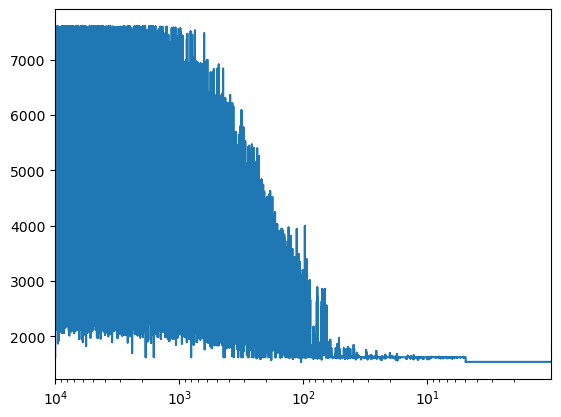

In [155]:
m = []
for i in range(20):
  area = random.randint(50,100)
  m.append(Module(str(i), area, [1.]))

F = [m[0]]
for i in range(1, len(m)):
  F.append(m[i])
  F.append('V')
Fmin, Cmin = sa(1, 10000, 10000, 0.99, F, costEval, accept, perturb)
sumarea = sum([i._area for i in m])
print("Cost :", Cmin, "Utilization :", sumarea * 100./Cmin)
print("Final slicing FP :", Fmin)


In [156]:
class Position:
  def __init__(self, name, origin = (0.,0.), operator = None, left = None, right = None, xy = None):
    self._name = name
    self._origin = origin
    self._operator = operator
    self._left = left
    self._right = right
    if None == xy and self._right and self._left:
      ax, ay = self._left._xy
      bx, by = self._right._xy
      self._xy = (max(ax, bx), ay + by) if self._operator == 'H' else (ax + bx, max(ay, by))
    else:
      self._xy = xy
  def __repr__(self):
    return f'\n[{self._name}  origin:{self._origin} op:{self._operator} dim:{self._xy}]'

def findCoord(F):
  evalOrder = [] # stack
  stackTracker = []
  for i in range(len(F)):
    f = F[i]
    if f in operators:
      a = evalOrder.pop()
      b = evalOrder.pop()
      stackTracker.append(b)
      stackTracker.append(a)
      evalOrder.append(Position(f+f'_{i}', (0,0), f, b, a))
    else:
      evalOrder.append(Position(f._name, (0,0), None, None, None, f._xy[0]))
  assert(len(evalOrder) == 1)
  stackTracker.append(evalOrder.pop())
  for i in range(len(stackTracker)-1, -1, -1):
    curr = stackTracker[i]
    if curr._operator in operators:
      curr._left._origin = (curr._origin[0], curr._origin[1])
      if curr._operator == 'H':
        curr._right._origin = (curr._origin[0], curr._origin[1] + curr._left._xy[1])
      elif curr._operator == 'V':
        curr._right._origin = (curr._origin[0] + curr._left._xy[0], curr._origin[1])

  coord = [(c._origin, c._xy, c._name) for c in stackTracker if c._operator not in operators]
  return coord

def plotSolution(F):
  coords=findCoord(F)
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle

  fig, ax = plt.subplots()
  ax.plot([0, 0])
  ax.set_aspect('equal')
  ax.set_xlim(0,max([r[0][0] + r[1][0] for r in coords]))
  ax.set_ylim(0,max([r[0][1] + r[1][1] for r in coords]))

  for i,r in enumerate(coords):
    match i%4:
      case 3: hatch, color = '/+', 'red'
      case 2: hatch, color = '///', 'green'
      case 1: hatch, color = '/\//\//\/', 'blue'
      case _: hatch, color = '\\\\\\', 'gray'
    ax.add_patch(Rectangle(r[0], r[1][0], r[1][1],
              edgecolor = 'black',
              hatch=hatch, fill = False, color=color,
              lw=2))
    ax.text(r[0][0] + r[1][0]//2, r[0][1] + r[1][1]//2, r[2], fontsize=8)
  plt.show()


/tmp/ipykernel_2097036/1493559617.py:61: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Rectangle(r[0], r[1][0], r[1][1],


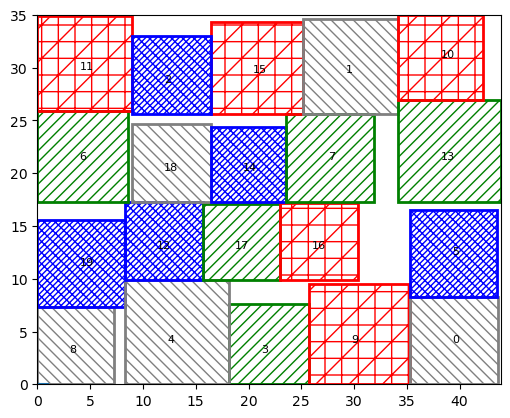

In [157]:
plotSolution(Fmin)